# TI3130: Regression &mdash; Exercises
**Julián Urbano &mdash; December 2023**

In [2]:
import sys
import numpy as np
import pandas as pd
from plotnine import *
from plotnine import __version__ as p9__version__
import statsmodels.api as sm
import statsmodels.formula.api as smf

print("python", sys.version,
      "\nnumpy", np.__version__,
      "\npandas", pd.__version__,
      "\nplotnine", p9__version__,
      "\nstatsmodels", sm.__version__)

python 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)] 
numpy 1.26.1 
pandas 2.1.3 
plotnine 0.12.4 
statsmodels 0.14.0


For these exercises we will use the _AirBnB Berlin_, _Amsterdam Lite_, _Advertising_, _Wages_ and _Diamonds_ datasets. Please refer to their HTML files for a description of the variables.

In [3]:
listings = pd.read_csv('airbnb_listings.csv')
ams = pd.read_csv('amsterdam_lite.csv')
adv = pd.read_csv('advertising.csv')
wage = pd.read_csv('wages.csv')
diamonds = pd.read_csv('diamonds.csv')

**Slide numbers refer to the page of the slides PDF, not the recordings.** Page _Lx_ refers to page _x_ of the _The Linear Model_ lecture. Page _Rx_ refers to page _x_ of the _Regression_ lecture.

**1) Compute the RMSE and $R^2$ of the model `sales ~ tv` (see slide L18), without using Statsmodels' built-in functions.**

In [4]:
m = smf.ols('sales ~ tv', adv).fit()
RSS = np.sum(np.square(m.resid))
n = adv.shape[0]
RMSE = np.sqrt((1/n)*RSS)
print(f'RMSE: {RMSE}')
y_mean = np.mean(adv['sales'])
TSS = np.sum(np.square(adv['sales'] - y_mean))
R_squared = 1 - (RSS/TSS)
print(f'R_squared: {R_squared}')

RMSE: 3.2423221486546887
R_squared: 0.611875050850071


**2) In the tutorial, we fitted a logistic model to predict `unemployment` with `inc_income`. Try fitting this model yourself using plain OLS on the logit-transformed response. Compare the estimates and regression lines from both models. Why are they different?**

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,-0.9584,0.710,-1.349,0.177,-2.351,0.434
inc_income,-3.867e-05,2.01e-05,-1.929,0.054,-7.8e-05,6.26e-07


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.3164,0.049,-26.787,0.000,-1.413,-1.220
inc_income,-2.981e-05,1.21e-06,-24.557,0.000,-3.22e-05,-2.74e-05


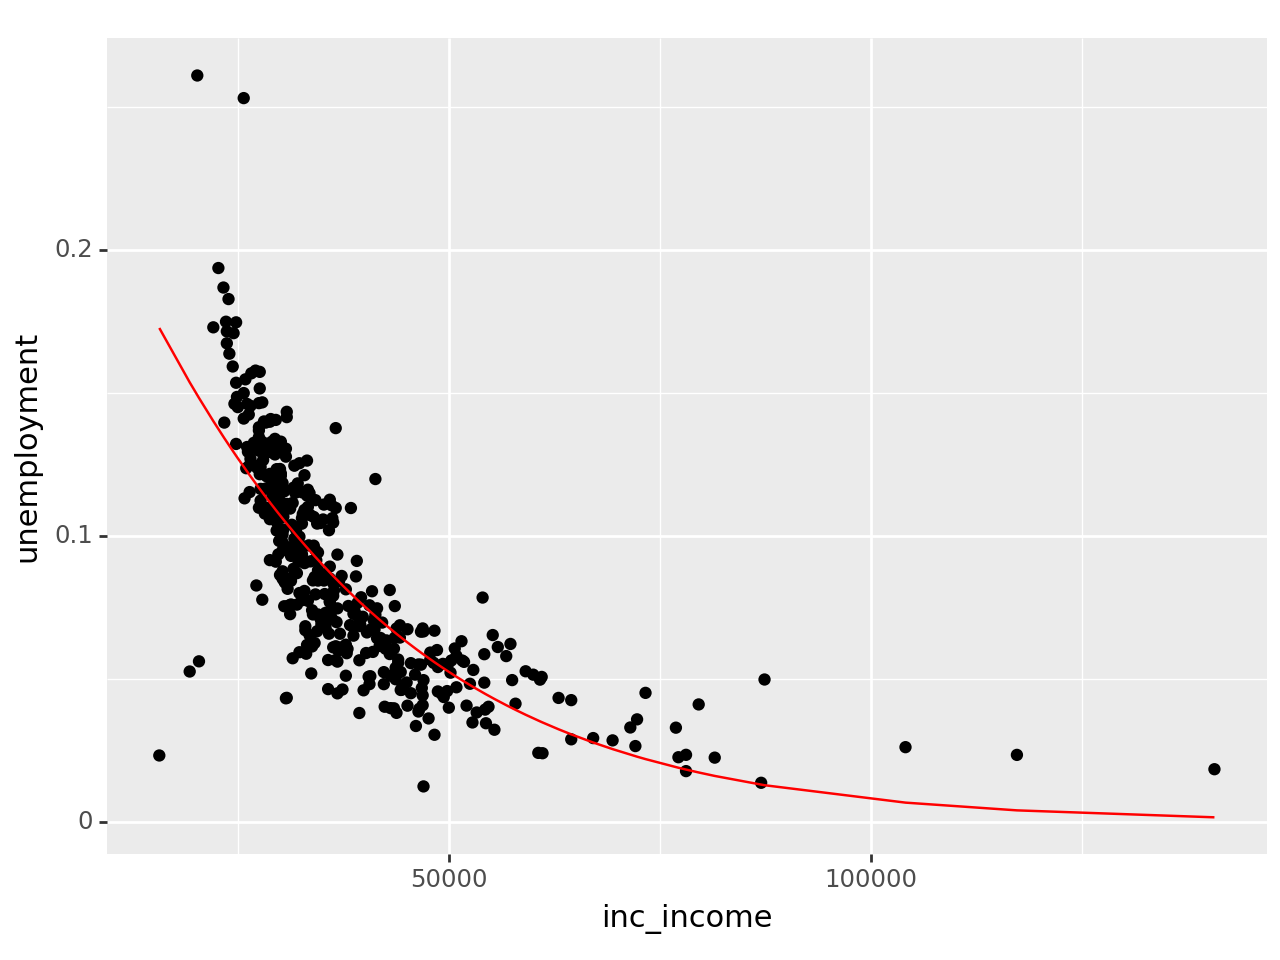

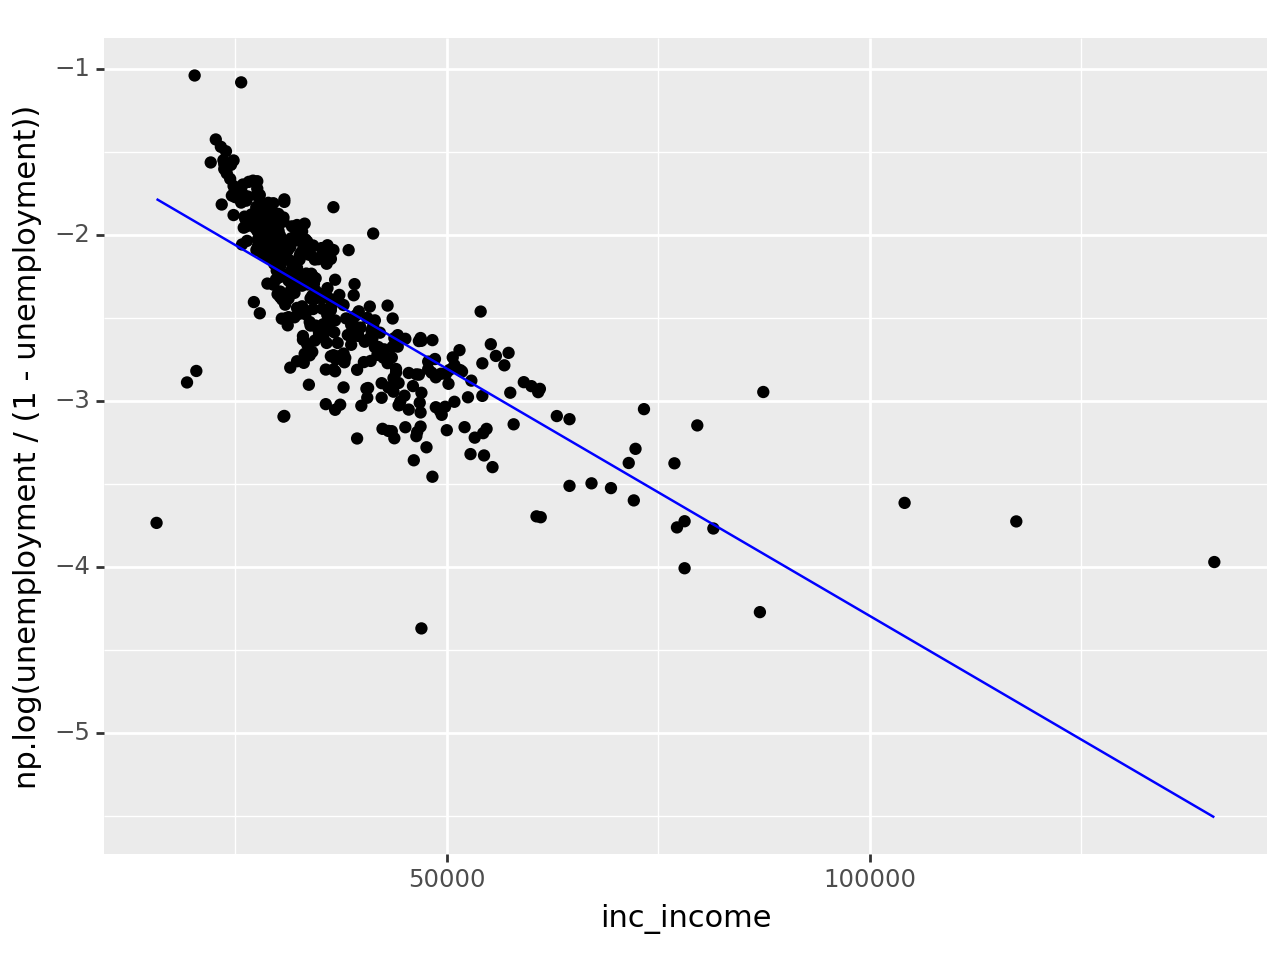

In [5]:
ams = ams.assign(unemployment = ams.pop_unemployed / ams.pop_total)

# logit regression, as in the tutorial
m1 = smf.glm('unemployment ~ inc_income', ams, family = sm.families.Binomial()).fit()
display(m1.summary().tables[1])

# OLS on the logit transformed response
m2 = smf.ols('np.log(unemployment / (1 - unemployment)) ~ inc_income', ams).fit()
display(m2.summary().tables[1])

d1 = ams.assign(_fitted1 = m1.fittedvalues)
d2 = ams.assign(_fitted2 = m2.fittedvalues)

g1 = ggplot(d1, aes('inc_income', 'unemployment')) +\
    geom_point() +\
    geom_line(aes(y = '_fitted1'), color = 'red')
g2 = ggplot(d2, aes('inc_income', 'np.log(unemployment / (1 - unemployment))')) +\
    geom_point() +\
    geom_line(aes(y = '_fitted2'), color = 'blue')

print(g1)
print(g2)

# The estimates in m1 model are larger than in m2. The regression line of m1 is curved whereas the regression line of m2 is straight.
# These differences occur because the interpretation of the dependent variable is different in these two models.

**3) Build a logistic model to predict `unemployment` with `inc_gini` and `district`. Show the regression lines in both the link space and the response space, as we did in slide R69, using different colors for `district`s.**

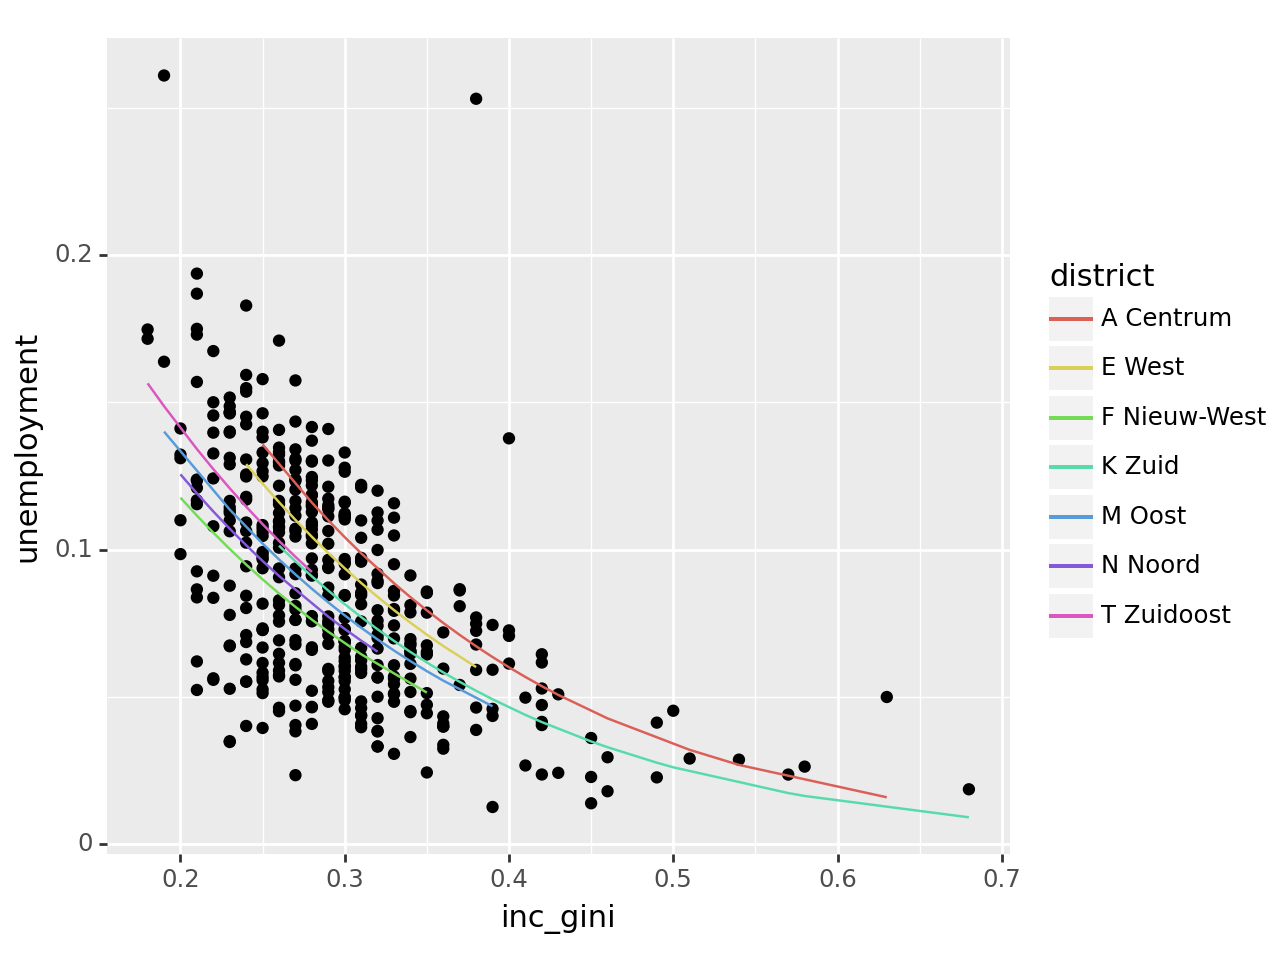

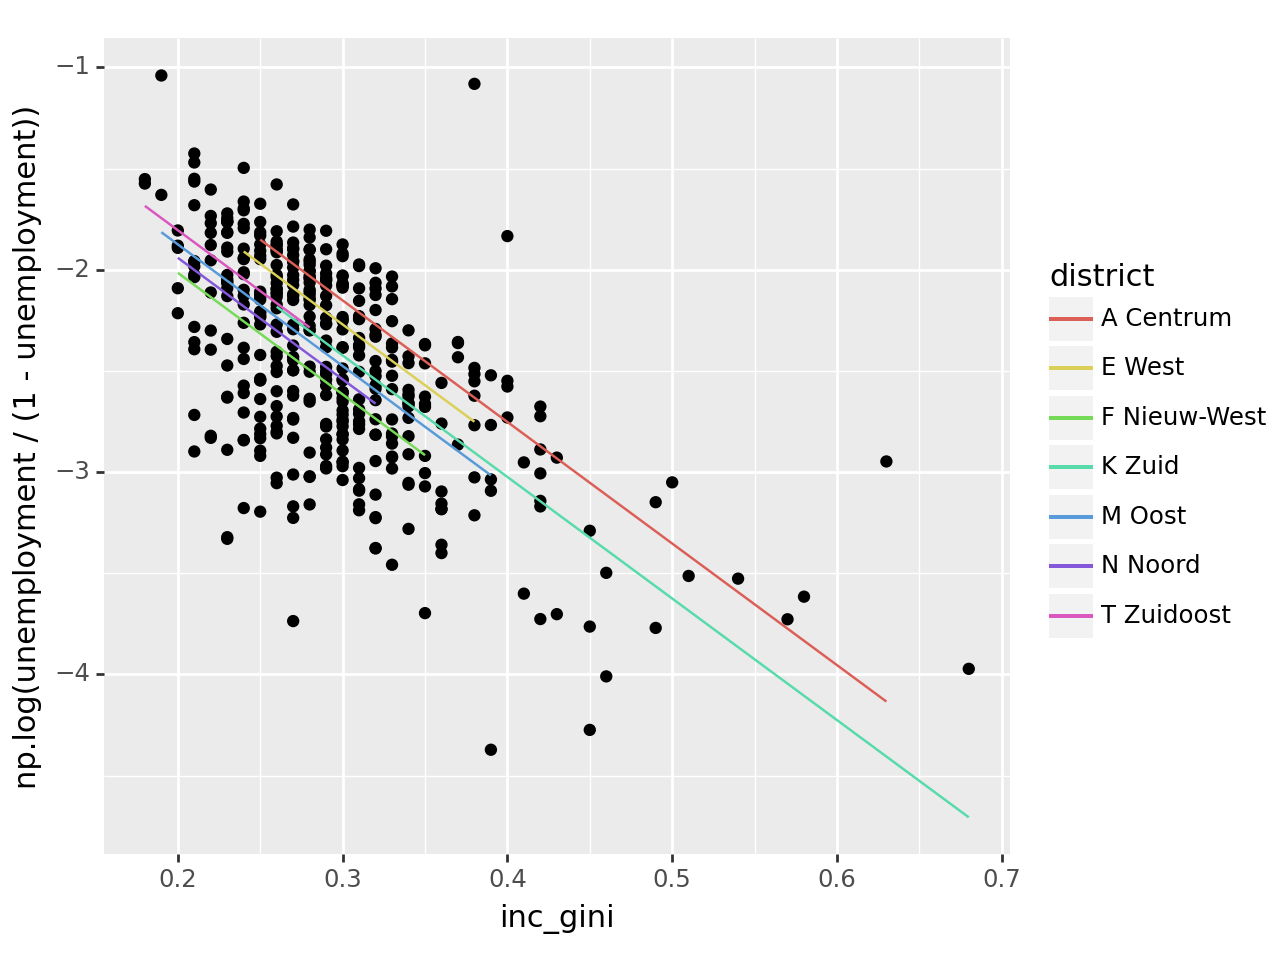

In [6]:
ams = ams.assign(unemployment = ams.pop_unemployed / ams.pop_total)

m = smf.glm('unemployment ~ inc_gini + district', ams, family = sm.families.Binomial()).fit()
d_response = ams.assign(_fitted = m.fittedvalues)
d_link = ams.assign(_fitted = m.family.link(m.fittedvalues))
g_response = ggplot(ams, aes('inc_gini', 'unemployment')) +\
    geom_point() +\
    geom_line(aes(y = '_fitted', colour = 'district'), data = d_response)
g_link = ggplot(ams, aes('inc_gini', 'np.log(unemployment / (1 - unemployment))')) +\
    geom_point() +\
    geom_line(aes(y = '_fitted', colour = 'district'), data = d_link)

print(g_response)
print(g_link)

**4) In the tutorial we fitted a logistic model `unemployment ~ I(1/inc_income)*spa_playing`, and plotted it in the response space. However, the regression lines did not span the whole range of `inc_income` because we plotted them only at observed values of `inc_income` (eg. there are no observations of high `inc_income` for `spa_playing=1.low`). Make a new plot making sure the lines _do_ span the whole range. Functions [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html) and [`pd.merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) (with `how='cross'`) will be useful.**

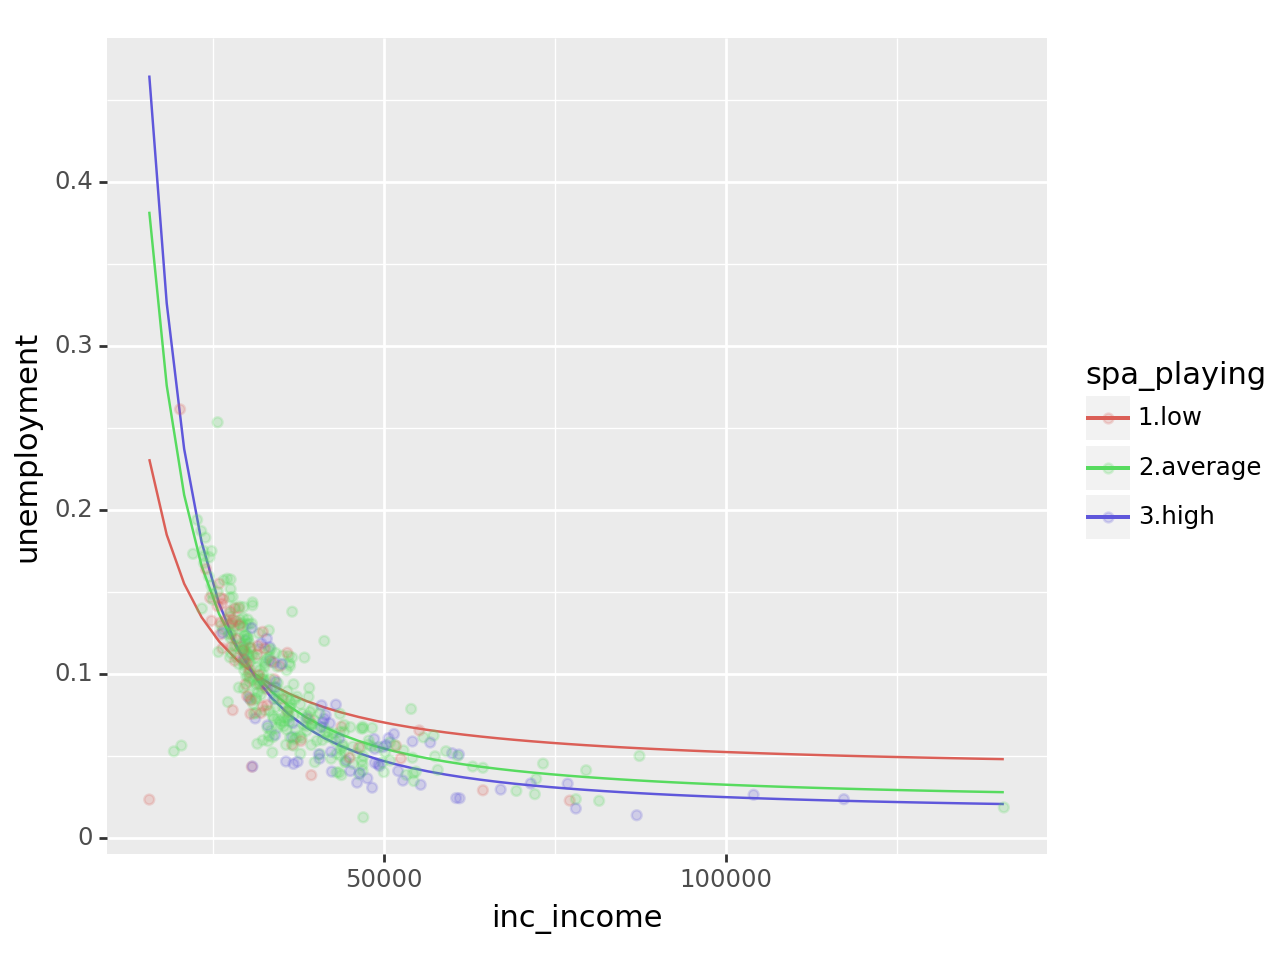

<Figure Size: (640 x 480)>

In [7]:
ams = ams.assign(unemployment = ams.pop_unemployed / ams.pop_total)

# model from the tutorial
m = smf.glm('unemployment ~ I(1/inc_income)*spa_playing', ams, family = sm.families.Binomial()).fit()

inc_income_range = np.linspace(ams['inc_income'].min(), ams['inc_income'].max())
spa_playing_values = ['1.low', '2.average', '3.high']

merged = pd.merge(pd.DataFrame({'inc_income': inc_income_range}), 
    pd.DataFrame({'spa_playing': spa_playing_values}), 
    how='cross')
    
merged = merged.assign(unemployment = m.predict(merged))

ggplot(merged, aes('inc_income', 'unemployment', color = 'spa_playing')) +\
    geom_line(aes(y = 'unemployment')) +\
    geom_point(ams, aes(x='inc_income', y='unemployment', color='spa_playing'), alpha=0.2)

**5) Try reproducing the table in slide R23. You will get different results. Why? Now try reproducing the table in slide R24. You will get the same results. Why? And why do all $p$-values suddenly get so small?**

In [8]:
m1 = smf.ols('wage ~ status', wage).fit()
display(m1.summary().tables[1])

# The results differ because the reference value differs:
# in the slides, the reference value is 'never married', while here it is 'divorced'

m2 = smf.ols('wage ~ status -1', wage).fit()
display(m2.summary().tables[1])

# The results are now the same because the intercept is removed,
# so both regressions are performed with the same set of depended variables.
# The p-values got small because the interpretation of the estimated coeficients has changed
# due to the intercept being removed.
# In the first table, the estimates and the p-values describe the difference in effects marital status has compared to being divorced,
# whereas in the second one the estimates describe the averages for that specific group.
# Since the wage is never 0, the average wage for all marital status groups is never 0, so the p - values get really small.


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,103.1593,2.820,36.581,0.000,97.630,108.689
status[T.married],15.7010,2.955,5.312,0.000,9.906,21.496
status[T.never married],-10.4246,3.234,-3.224,0.001,-16.765,-4.084
status[T.separated],-1.9435,6.120,-0.318,0.751,-13.943,10.056
status[T.widowed],-3.6206,9.661,-0.375,0.708,-22.564,15.323


,coef,std err,t,P>|t|,[0.025,0.975]
status[divorced],103.1593,2.820,36.581,0.000,97.630,108.689
status[married],118.8603,0.884,134.391,0.000,117.126,120.594
status[never married],92.7346,1.582,58.608,0.000,89.632,95.837
status[separated],101.2158,5.431,18.636,0.000,90.567,111.865
status[widowed],99.5387,9.241,10.772,0.000,81.420,117.657


**6) The following code shows the bulk of the residual vs fitted plot for a model predicting `hou_value` with `inc_income` alone. Note that we use color to identify `district`s. What patterns do you see in the plot, and how do you explain them? How would you change the model after seeing this plot?**

c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 19 rows containing missing values.


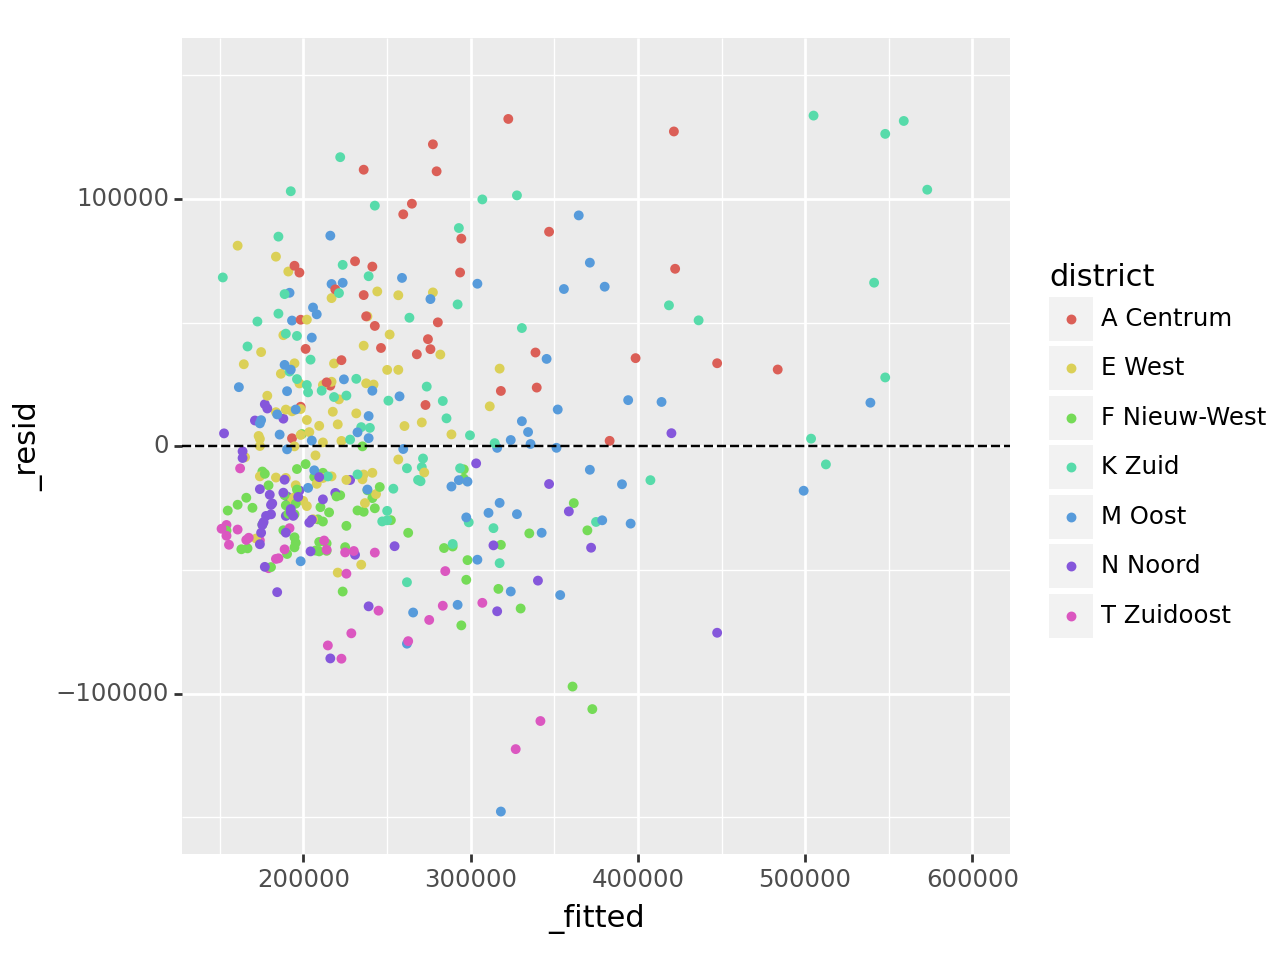

<Figure Size: (640 x 480)>

In [9]:
m = smf.ols('hou_value ~ inc_income', ams).fit()

d = ams.assign(_resid = m.resid, _fitted = m.fittedvalues)

ggplot(d, aes('_fitted', '_resid', color = 'district')) +\
  geom_point(size = 1) +\
  geom_hline(yintercept = 0, linetype = 'dashed') +\
  xlim(150000, 600000) + ylim(-150000, 150000)

In [10]:
# There seems to be some clusering of residual values for the observations within the same district.
# This indicates that the district has an effect on the average house-value,
# therefore district should be included in the model.
# Additionally, the magnitude of the residual increases when the fitted values get larger.
# Such distribution of the residuals suggest possible heteroskedasticity,
# therefore a log term transformation should be performed.

**7) The lecture on EDA (see slide 95) showed that the relationship between a diamond's `price` and `carat` can be better explained by 1) a log-log transformation, and 2) the use of `clarity` as a moderator variable. Use linear models to confirm those two observations, explaining your reasoning.**

simple model R squared: 0.8493305264354858


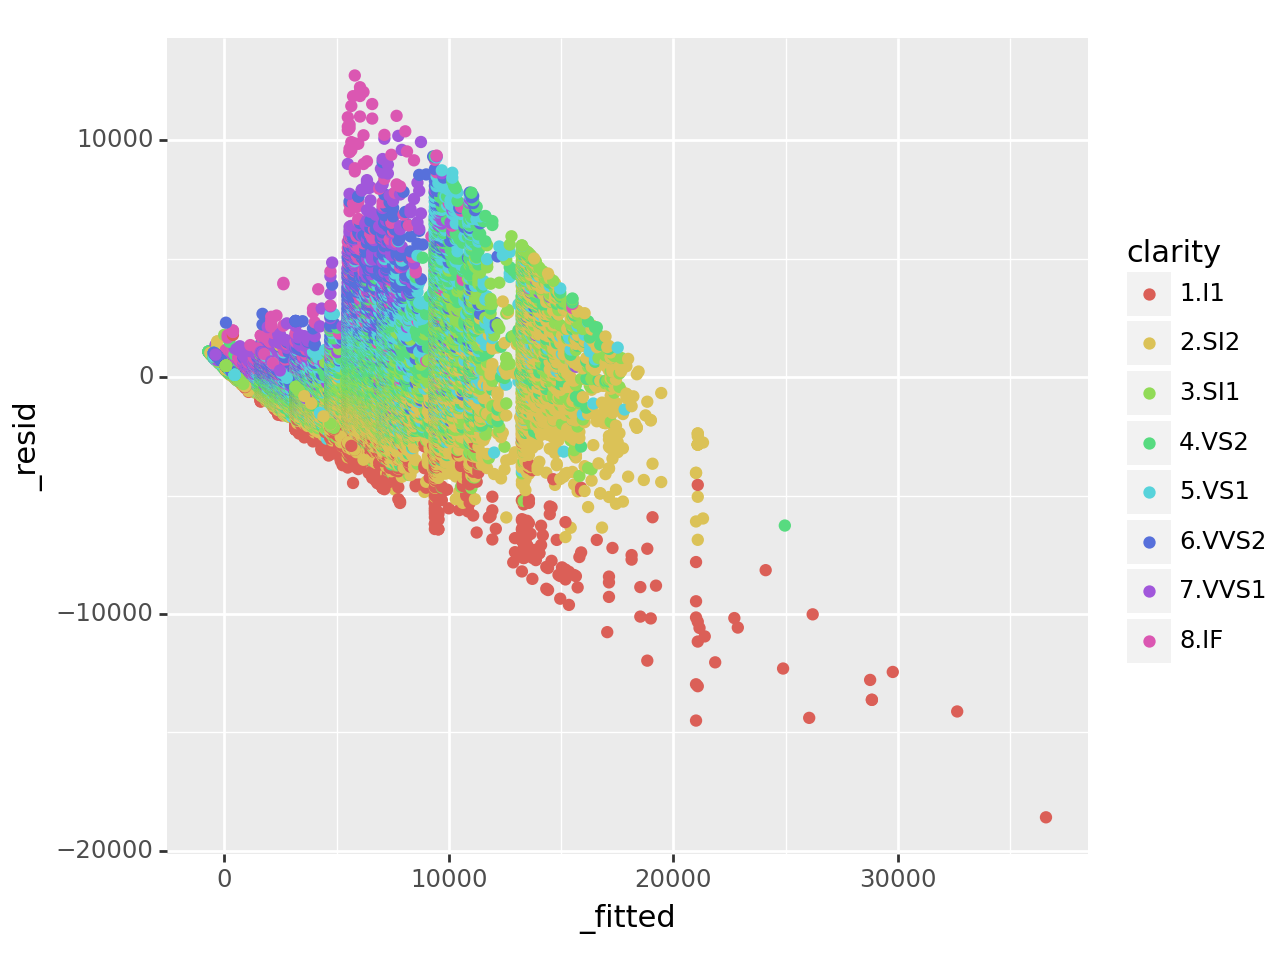

<Figure Size: (640 x 480)>

log-log model R squared: 0.9329893079520857


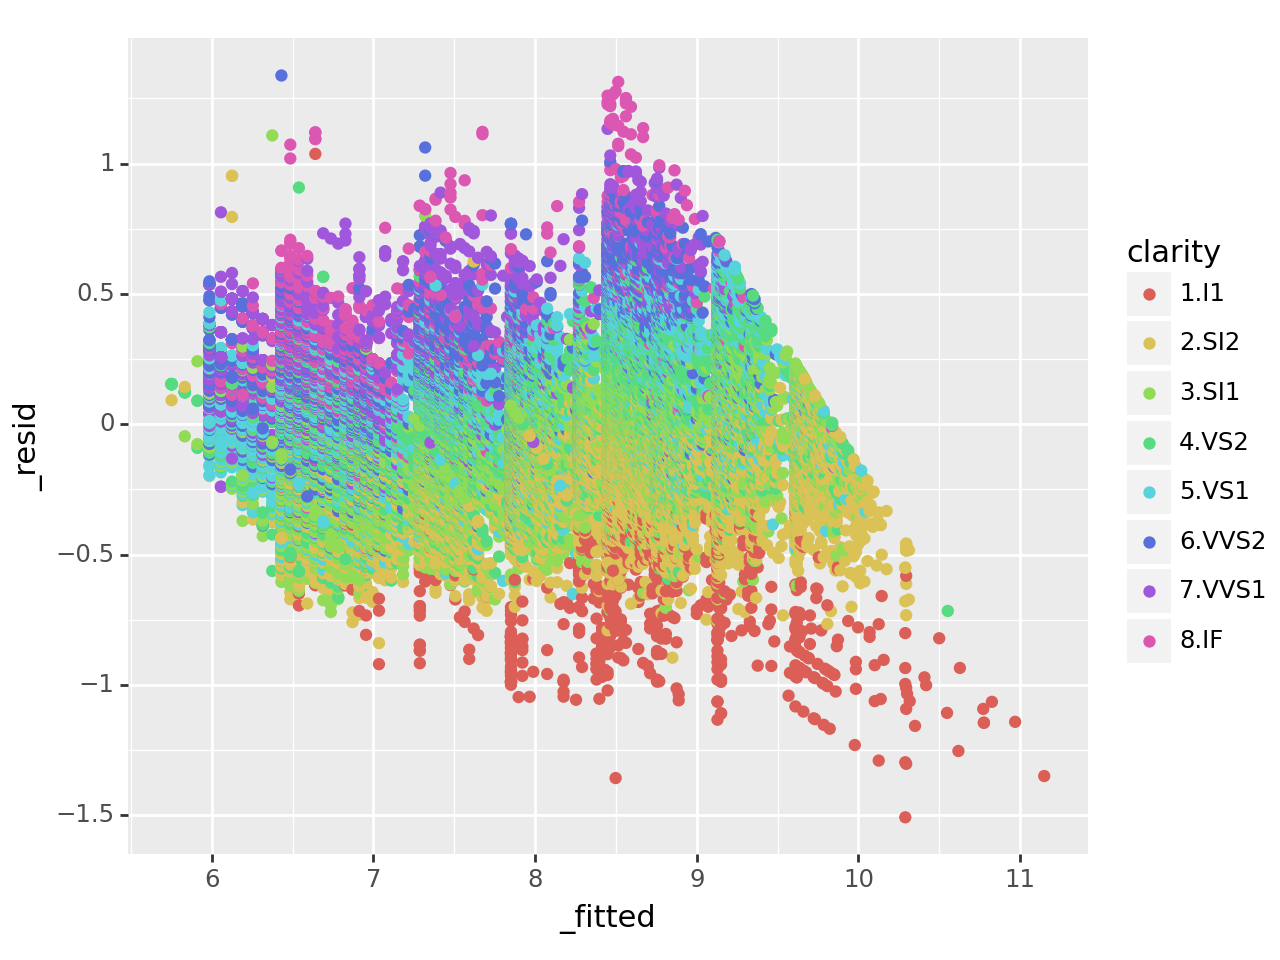

<Figure Size: (640 x 480)>

R squared of log-log model with clarity included: 0.9653683913877744


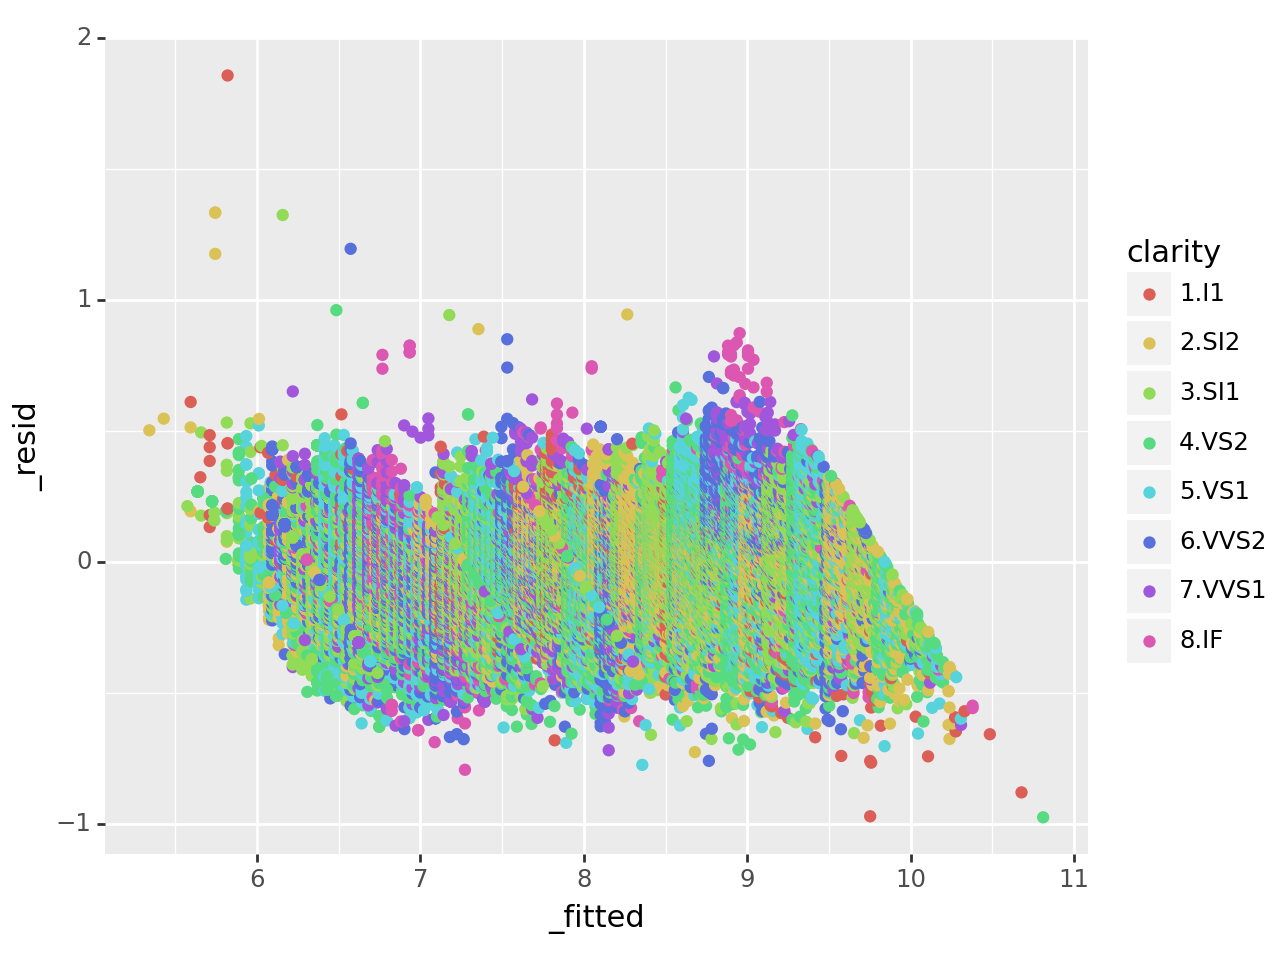

<Figure Size: (640 x 480)>

In [11]:
# Simple model PRICE ~ CARAT
m0 = smf.ols('price ~ carat', diamonds).fit()
print(f'simple model R squared: {m0.rsquared}')
d0 = diamonds.assign(_resid = m0.resid, _fitted = m0.fittedvalues)
g0 = ggplot(d0, aes('_fitted', '_resid', color = 'clarity')) +\
  geom_point()
display(g0)

# Log-log model log(PRICE) ~ log(CARAT)
m1 = smf.ols('np.log(price) ~ np.log(carat)', diamonds).fit()
print(f'log-log model R squared: {m1.rsquared}')
d1 = diamonds.assign(_resid = m1.resid, _fitted = m1.fittedvalues)
g1 = ggplot(d1, aes('_fitted', '_resid', color = 'clarity')) +\
  geom_point()
display(g1)

# Log-log model log(PRICE) ~ log(CARAT) + CLARITY
m2 = smf.ols('np.log(price) ~ np.log(carat) + clarity', diamonds).fit()
print(f'R squared of log-log model with clarity included: {m2.rsquared}')
d2 = diamonds.assign(_resid = m2.resid, _fitted = m2.fittedvalues)
g2 = ggplot(d2, aes('_fitted', '_resid', color = 'clarity')) +\
  geom_point()
display(g2)

# Log-log model is a better fit, because it has a larger R squared value than the simple model.
# Additionally, the distribution of residuals of the log-log model is much more symetric.
# However, in both simple and log-log model that does not include clarity as a moderator variable,
# there is a distinct clustering of residuals of the same clarity type,
# which gets resolved one clarity is introduced to the model.

**8) Slide 73 in the EDA lecture showed an interaction between `room_type` and `neighborhood_group` as predictors of `price` (note that we explicitly filter out listings with a price over 250€): in neighborhoods _Pankow_, _Reinickendorf_ and _Tempelhof - Schöneberg_ private rooms are cheaper than shared rooms. The linear model below confirms this, but the coefficients are surprising. The interaction coefficients in _Reinickendorf_ (ie. 5.0590 < 103.8101) and _Tempelhof - Schöneberg_ (ie. -1.8571 < 32.3572) align with this observation, but not in _Pankow_ (ie. -6.4799 > -7.9610). Why is that, knowing that the real difference between private and shared rooms in _Pankow_ is indeed 17.8854?**

In [12]:
m = smf.ols('price ~ room_type*neighborhood_group', listings.query('price <= 250')).fit()
m.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,76.8216,2.091,36.744,0.000,72.723,80.920
room_type[T.Private room],-31.1409,3.492,-8.917,0.000,-37.987,-24.295
room_type[T.Shared room],-11.7744,6.813,-1.728,0.084,-25.131,1.582
neighborhood_group[T.Friedrichshain-Kreuzberg],-1.5069,2.404,-0.627,0.531,-6.220,3.206
neighborhood_group[T.Lichtenberg],-12.2867,5.101,-2.409,0.016,-22.288,-2.286
neighborhood_group[T.Marzahn - Hellersdorf],-13.0569,7.690,-1.698,0.090,-28.133,2.019
neighborhood_group[T.Mitte],4.2638,2.477,1.721,0.085,-0.593,9.121
neighborhood_group[T.Neukölln],-15.1317,2.571,-5.886,0.000,-20.172,-10.092
neighborhood_group[T.Pankow],2.3138,2.439,0.949,0.343,-2.467,7.094
neighborhood_group[T.Reinickendorf],-18.8573,6.134,-3.074,0.002,-30.882,-6.832


In [13]:
# We remove room_type and neighborhood_group from the model, leaving only the interaction effects:
m = smf.ols('price ~ room_type:neighborhood_group - room_type - neighborhood_group', listings.query('price <= 250')).fit()
m.summary().tables[1]
# Now the estimates for Pankow neighborhood_group are as follows
# Private room:	-37.6208
# Shared room:	-19.7354
# Now the values are just as expected: -19.7354 - (-37.6208) = 17.8854
# The estimates did not make sense before due to multicollinearity between main effect and interaction effect variables.

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,76.8216,2.091,36.744,0.000,72.723,80.920
neighborhood_group[T.Friedrichshain-Kreuzberg],-1.5069,2.404,-0.627,0.531,-6.220,3.206
neighborhood_group[T.Lichtenberg],-12.2867,5.101,-2.409,0.016,-22.288,-2.286
neighborhood_group[T.Marzahn - Hellersdorf],-13.0569,7.690,-1.698,0.090,-28.133,2.019
neighborhood_group[T.Mitte],4.2638,2.477,1.721,0.085,-0.593,9.121
neighborhood_group[T.Neukölln],-15.1317,2.571,-5.886,0.000,-20.172,-10.092
neighborhood_group[T.Pankow],2.3138,2.439,0.949,0.343,-2.467,7.094
neighborhood_group[T.Reinickendorf],-18.8573,6.134,-3.074,0.002,-30.882,-6.832
neighborhood_group[T.Spandau],3.1784,10.989,0.289,0.772,-18.365,24.721
neighborhood_group[T.Steglitz - Zehlendorf],-5.3401,4.649,-1.149,0.251,-14.454,3.774


**9) The following table shows the reference grid to compute Estimated Marginal Means from a model that predicts a neighborhood's population as a function of three categorical predictors. Using this grid, calculate the EMM estimates for 1) each category of `saf_catering`, and 2) `saf_neighbors=1.high` faceted by `saf_catering`.**

|    | saf_neighbors | saf_catering | spa_streets | prediction |
|----|---------------|--------------|-------------|------------|
| 1  | 1.low         | 1.low        | 1.low       | 3058       |
| 2  | 2.high        | 1.low        | 1.low       | 2958       |
| 3  | 1.low         | 2.high       | 1.low       | 3220       |
| 4  | 2.high        | 2.high       | 1.low       | 3121       |
| 5  | 1.low         | 1.low        | 2.average   | 2691       |
| 6  | 2.high        | 1.low        | 2.average   | 2591       |
| 7  | 1.low         | 2.high       | 2.average   | 2853       |
| 8  | 2.high        | 2.high       | 2.average   | 2754       |
| 9  | 1.low         | 1.low        | 3.high      | 2481       |
| 10 | 2.high        | 1.low        | 3.high      | 2382       |
| 11 | 1.low         | 2.high       | 3.high      | 2644       |
| 12 | 2.high        | 2.high       | 3.high      | 2544       |

In [14]:
#  calculate the EMM estimates for
# 1) each category of `saf_catering`
EMM_low = (3058 + 2958 + 2691 + 2481 + 2382) / 6
EMM_high = (3220 + 3121 + 2853 + 2754 + 2644 + 2544) / 6
print(f'1) saf_catering = low: EMM = {EMM_low}, saf_catering = high: EMM = {EMM_high}')
# 2) `saf_neighbors=1.high` faceted by `saf_catering`
EMM_low_1 = (2958 + 2591 + 2382) / 3
EMM_high_1 = (3121 + 2754 + 2544) / 3
print(f'2) saf_neighbors = high: saf_catering = low: EMM = {EMM_low_1}, saf_catering = high: EMM = {EMM_high_1}')


1) saf_catering = low: EMM = 2261.6666666666665, saf_catering = high: EMM = 2856.0
2) saf_neighbors = high: saf_catering = low: EMM = 2643.6666666666665, saf_catering = high: EMM = 2806.3333333333335


**10) Create an _unambiguous_ and _nontrivial_ question, and its corresponding solution, as if you were writing the set of exercises for the lab. The question must cover at least 3 of the following aspects:**

- **Categorical predictors or interactions**
- **Interpretation of coefficients/predictions or their precision**
- **Transformations**
- **Model diagnostics, visualization**
- **Logistic regression**
- **Open-ended conceptual question to explain some behavior**

**Please make it explicit which 3 of these aspects your question covers. You can use any of the datasets available on Brightspace.**

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.496
Date:                Mon, 18 Dec 2023   Prob (F-statistic):           9.61e-05
Time:                        16:12:29   Log-Likelihood:                -30046.
No. Observations:                5000   AIC:                         6.014e+04
Df Residuals:                    4976   BIC:                         6.030e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 7 rows containing missing values.


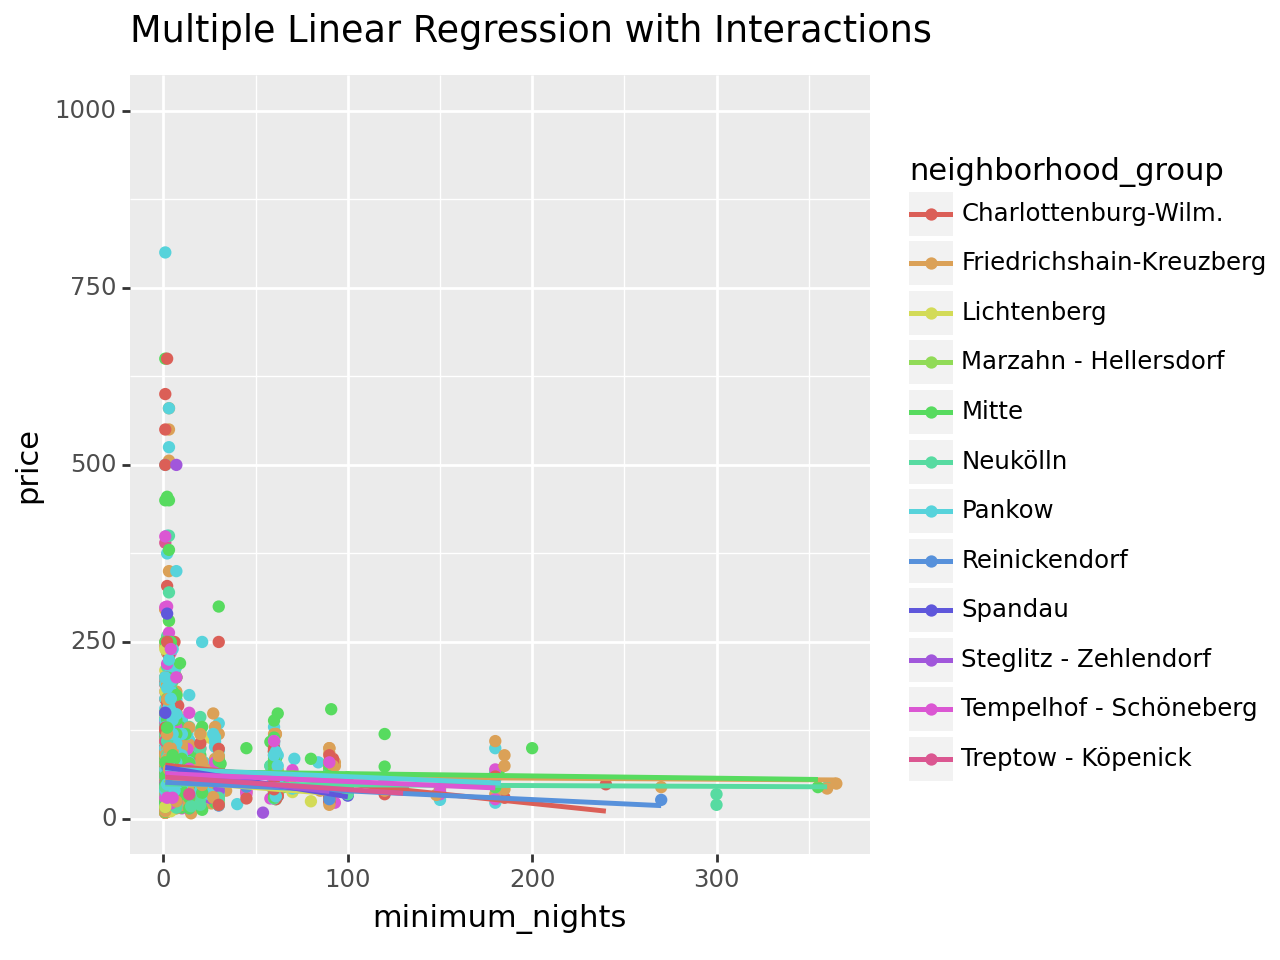

c:\Users\EgleS\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 5 rows containing missing values.


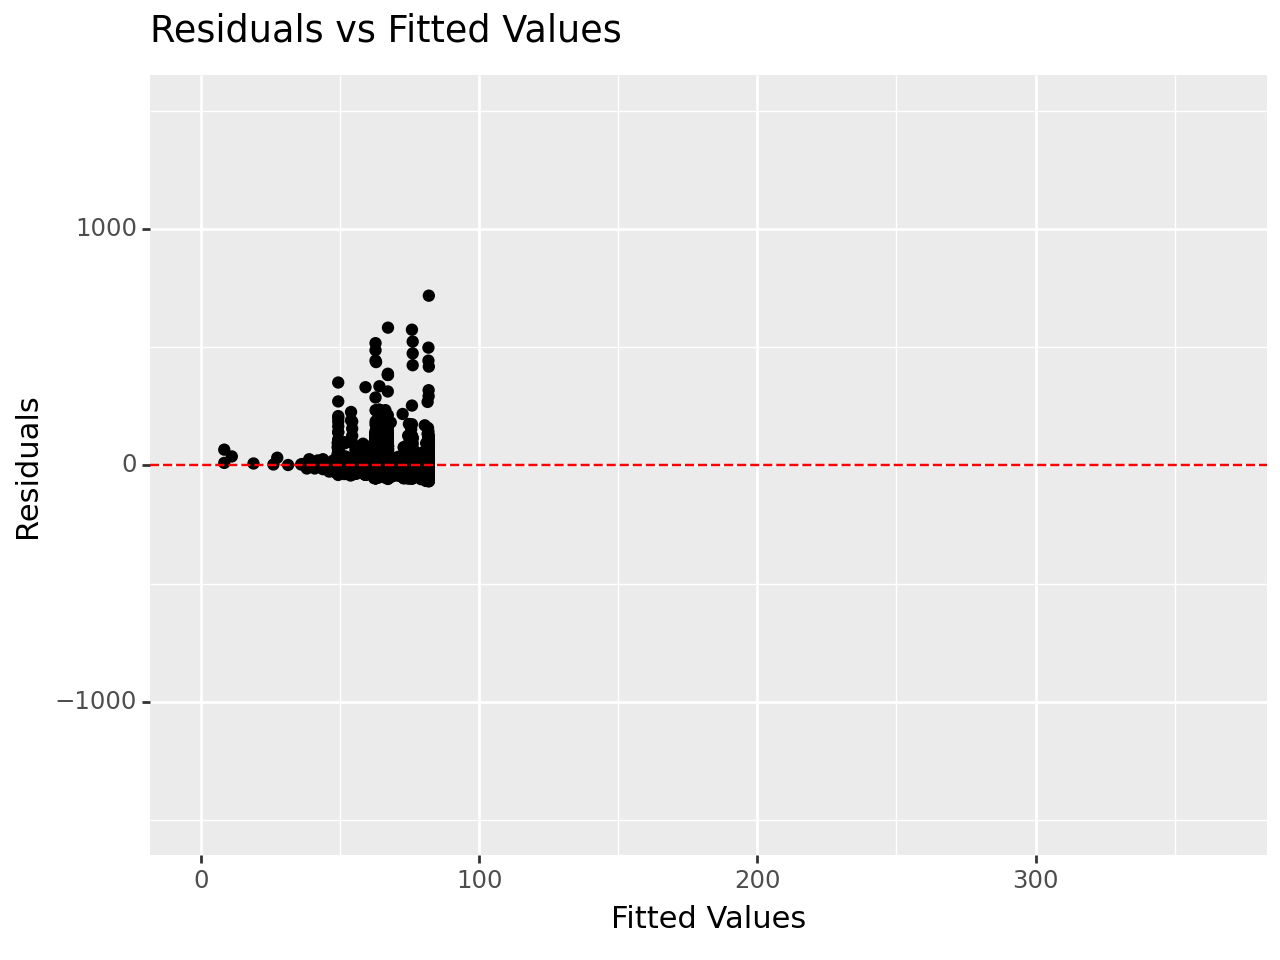

In [15]:
#Analyze the relatioship between  advertising spending, income, and product sales 
#Use advertising.csv
#Make a multiple linear relationship model
#Must include interactions between the categorical predictor 'tv' and the continuous predictor 'radio'
#Watch out for transformations and interpret results and predictions
#Discuss if a transformationn will be required
#aspects covered
    #Categorical predictors or interactions:
    #Interpretation of coefficients/predictions or their precision: 
    #Model diagnostics, visualization:

# Loading the Airbnb dataset
d = pd.read_csv('airbnb_listings.csv')

# Creating a multiple linear regression model with interactions
model_formula = 'price ~ minimum_nights * neighborhood_group'
model = smf.ols(formula=model_formula, data=d).fit()

# Displaying the model summary
print(model.summary())

# Plot results
plot = (
    ggplot(d, aes(x='minimum_nights', y='price', color='neighborhood_group')) +
    geom_point() +
    geom_smooth(method='lm', se=False) +
    labs(title='Multiple Linear Regression with Interactions', x='minimum_nights', y='price', color='neighborhood_group') +
    xlim(0, 365) + ylim(0, 1000) 
)

print(plot)

# Model diagnostics
residuals = model.resid
fitted_values = model.fittedvalues

# Residual plot
residual_plot = (
    ggplot(pd.DataFrame({'Fitted Values': fitted_values, 'Residuals': residuals}), aes(x='Fitted Values', y='Residuals')) +
    geom_point() +
    geom_hline(yintercept=0, linetype='dashed', color='red') +
    labs(title='Residuals vs Fitted Values', x='Fitted Values', y='Residuals', color= 'neighborhood_group') +
    xlim(0, 365) + ylim(-1500, 1500)
)

print(residual_plot)
#As we can see with the p_values the relationship between price, neighbourhood and min nights is statistically irrelevant in 4 neighborhood groups
#This can be seen clearly in the graph although it can also be seen that the relationship would benefit with a transformation
#Also the std error seems to be quite high
#The residuals graph shows that most of the residuals are positive due to the predictions being too low for the actual price
#Overall if a data transformation was performed a more prominent relationship could be found between price, neigbourhood group and minimum nights